# **Text Language Identification**

Identification of language of given text is ddown by Transfer Learning Approach 

## Using Bidirectional Representation for Transformers (BERT Pre-trained Model).

In [2]:
pip uninstall tensorflow

Uninstalling tensorflow-2.4.1:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.4.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.4.1


In [3]:
pip install tensorflow==1.15.0

     |████████████████████████████████| 412.3MB 41kB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 512kB 53.0MB/s 
     |████████████████████████████████| 3.8MB 43.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=d215007d97ae082b8478e2ce0219be1ea15ab2ee82ef02956eee6dd3dbe5c7f7
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninsta

In [4]:
pip install bert-tensorflow

     |████████████████████████████████| 71kB 8.7MB/s 


In [5]:
pip install transformers

     |████████████████████████████████| 2.1MB 14.0MB/s 
     |████████████████████████████████| 3.3MB 52.5MB/s 
     |████████████████████████████████| 901kB 43.9MB/s 


In [6]:
# Importing all the necessary Libraries
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
from sklearn.model_selection import train_test_split
import os

print("tensorflow version : ", tf.__version__)
print("tensorflow_hub version : ", hub.__version__)

tensorflow version :  1.15.0
tensorflow_hub version :  0.12.0


In [7]:
#Importing BERT modules
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization
from transformers import BertTokenizer

## Getting the Language Data

In [8]:
raw = pd.read_csv('dataset.csv')

In [9]:
raw.head()

,Text,language
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas på eng the jesuit...,Swedish
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil
4,de spons behoort tot het geslacht haliclona en...,Dutch


In [10]:
# Set the output directory for saving model file
OUTPUT_DIR = 'bert_language_identification'

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = True #@param {type:"boolean"}

if DO_DELETE:
    try:
        tf.gfile.DeleteRecursively(OUTPUT_DIR)
    except:
        pass

tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: bert_language_identification *****


In [11]:
# Spliting the data into training validation and testing data with split ratio of 80-10-10
train, inter = train_test_split(raw, test_size = 0.2, shuffle = True, random_state=42)
valid, test = train_test_split(inter, test_size = 0.5, shuffle = True, random_state=42)


In [12]:
DATA_COLUMN = 'Text'
LABEL_COLUMN = 'language'
labels = train['language'].unique()

In [ ]:
train['language'].value_counts().plot(kind = 'bar')

In [14]:
# Creating the Input Samples for training the BERT Model using run_classifier of BERT 
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = valid.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)


In [15]:
print("Row 0 - guid of training set : ", train_InputExamples.iloc[0].guid)
print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples.iloc[0].text_a)
print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples.iloc[0].text_b)
print("\n__________\nRow 0 - label of training set : ", train_InputExamples.iloc[0].label)

Row 0 - guid of training set :  None

__________
Row 0 - text_a of training set :  สัมประสิทธิ์ฮอลล์ ฟิสิกส์ไฟฟ้า เกี่ยวกับสนามแม่เหล็กที่ให้กับวัตถุ เทียบกับความต่างศักย์ที่สร้างขึ้น ปริมาณของกระแสไฟฟ้า และความหนาของวัตถุ เป็นลักษณะเฉพาะของวัสดุที่นำมาใช้ทำตัวนำไฟฟ้า

__________
Row 0 - text_b of training set :  None

__________
Row 0 - label of training set :  Thai


## Here for training I am using **bert_multi_cased_L-12_H-768_A-12/1** pre-trained model from pool of bert pre-trained model.

In [16]:
# Function for creating bert module and tokenizing the text using BertTokenizer

BERT_MODEL_HUB = "https://tfhub.dev/google/bert_multi_cased_L-12_H-768_A-12/1"


def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    with tf.Graph().as_default():
        bert_module = hub.Module(BERT_MODEL_HUB)
        tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
        with tf.Session() as sess:
            vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
    return BertTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)


In [17]:
# Creating bert module and tokenizing the text using BertTokenizer
tokenizer = create_tokenizer_from_hub_module()

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/bert_multi_cased_L-12_H-768_A-12/1'.
INFO:absl:Downloaded https://tfhub.dev/google/bert_multi_cased_L-12_H-768_A-12/1, Total size: 683.74MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/bert_multi_cased_L-12_H-768_A-12/1'.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [18]:
# Example of Tokenized Value
print(tokenizer.tokenize(train_InputExamples.iloc[0].text_a))

['ส', '##ั', '##ม', '##ป', '##ร', '##ะ', '##ส', '##ิ', '##ท', '##ธ', '##ิ์', '##ฮ', '##อล', '##ล์', 'ฟ', '##ิ', '##ส', '##ิก', '##ส์', '##ไ', '##ฟ', '##ฟ', '##้า', 'เ', '##ก', '##ี', '##่', '##ย', '##ว', '##กับ', '##ส', '##นา', '##ม', '##แ', '##ม', '##่', '##เ', '##ห', '##ล', '##็', '##ก', '##ที่', '##ใ', '##ห', '##้', '##กับ', '##ว', '##ั', '##ต', '##ถ', '##ุ', 'เ', '##ท', '##ีย', '##บ', '##กับ', '##ค', '##ว', '##าม', '##ต', '##่า', '##ง', '##ศ', '##ัก', '##ย์', '##ที่', '##ส', '##ร', '##้า', '##ง', '##ข', '##ึ', '##้น', 'ป', '##ร', '##ิม', '##า', '##ณ', '##ข', '##อง', '##กร', '##ะ', '##แ', '##ส', '##ไ', '##ฟ', '##ฟ', '##้า', 'และ', '##ค', '##ว', '##าม', '##ห', '##นา', '##ข', '##อง', '##ว', '##ั', '##ต', '##ถ', '##ุ', 'เป็น', '##ล', '##ัก', '##ษ', '##ณ', '##ะ', '##เ', '##ฉ', '##พ', '##า', '##ะ', '##ข', '##อง', '##ว', '##ัส', '##ด', '##ุ', '##ที่', '##น', '##ำ', '##มา', '##ใ', '##ช', '##้', '##ท', '##ำ', '##ต', '##ัว', '##น', '##ำ', '##ไ', '##ฟ', '##ฟ', '##้า']


In [19]:
# Set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128

# Convert train and validation features to InputFeatures that BERT understands.
train_features = run_classifier.convert_examples_to_features(train_InputExamples, labels, MAX_SEQ_LENGTH, tokenizer)

val_features = run_classifier.convert_examples_to_features(val_InputExamples, labels, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 17600


INFO:tensorflow:Writing example 0 of 17600


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] ส ##ั ##ม ##ป ##ร ##ะ ##ส ##ิ ##ท ##ธ ##ิ์ ##ฮ ##อล ##ล์ ฟ ##ิ ##ส ##ิก ##ส์ ##ไ ##ฟ ##ฟ ##้า เ ##ก ##ี ##่ ##ย ##ว ##กับ ##ส ##นา ##ม ##แ ##ม ##่ ##เ ##ห ##ล ##็ ##ก ##ที่ ##ใ ##ห ##้ ##กับ ##ว ##ั ##ต ##ถ ##ุ เ ##ท ##ีย ##บ ##กับ ##ค ##ว ##าม ##ต ##่า ##ง ##ศ ##ัก ##ย์ ##ที่ ##ส ##ร ##้า ##ง ##ข ##ึ ##้น ป ##ร ##ิม ##า ##ณ ##ข ##อง ##กร ##ะ ##แ ##ส ##ไ ##ฟ ##ฟ ##้า และ ##ค ##ว ##าม ##ห ##นา ##ข ##อง ##ว ##ั ##ต ##ถ ##ุ เป็น ##ล ##ัก ##ษ ##ณ ##ะ ##เ ##ฉ ##พ ##า ##ะ ##ข ##อง ##ว ##ัส ##ด ##ุ ##ที่ ##น ##ำ ##มา ##ใ ##ช ##้ ##ท [SEP]


INFO:tensorflow:tokens: [CLS] ส ##ั ##ม ##ป ##ร ##ะ ##ส ##ิ ##ท ##ธ ##ิ์ ##ฮ ##อล ##ล์ ฟ ##ิ ##ส ##ิก ##ส์ ##ไ ##ฟ ##ฟ ##้า เ ##ก ##ี ##่ ##ย ##ว ##กับ ##ส ##นา ##ม ##แ ##ม ##่ ##เ ##ห ##ล ##็ ##ก ##ที่ ##ใ ##ห ##้ ##กับ ##ว ##ั ##ต ##ถ ##ุ เ ##ท ##ีย ##บ ##กับ ##ค ##ว ##าม ##ต ##่า ##ง ##ศ ##ัก ##ย์ ##ที่ ##ส ##ร ##้า ##ง ##ข ##ึ ##้น ป ##ร ##ิม ##า ##ณ ##ข ##อง ##กร ##ะ ##แ ##ส ##ไ ##ฟ ##ฟ ##้า และ ##ค ##ว ##าม ##ห ##นา ##ข ##อง ##ว ##ั ##ต ##ถ ##ุ เป็น ##ล ##ัก ##ษ ##ณ ##ะ ##เ ##ฉ ##พ ##า ##ะ ##ข ##อง ##ว ##ัส ##ด ##ุ ##ที่ ##น ##ำ ##มา ##ใ ##ช ##้ ##ท [SEP]


INFO:tensorflow:input_ids: 101 1433 111427 17405 49292 22765 22598 28767 28220 37022 103641 91836 111426 85915 101063 1423 28220 28767 109453 33872 111435 72245 72245 43102 1450 18427 18260 31904 20503 31287 47260 28767 62904 17405 111432 17405 31904 111431 111424 20507 111437 18427 18203 111434 111424 35933 47260 31287 111427 30011 111419 53936 1450 37022 77654 49097 47260 31256 31287 79790 30011 38999 19197 50443 69365 27182 18203 28767 22765 43102 19197 80814 111428 49512 1419 22765 67093 17344 62914 80814 31142 95707 22598 111432 28767 111435 72245 72245 43102 15493 31256 31287 79790 111424 62904 80814 31142 31287 111427 30011 111419 53936 69450 20507 69365 103333 62914 22598 111431 111413 39901 17344 22598 80814 31142 31287 104125 22123 53936 18203 16000 55593 66845 111434 42407 35933 37022 102


INFO:tensorflow:input_ids: 101 1433 111427 17405 49292 22765 22598 28767 28220 37022 103641 91836 111426 85915 101063 1423 28220 28767 109453 33872 111435 72245 72245 43102 1450 18427 18260 31904 20503 31287 47260 28767 62904 17405 111432 17405 31904 111431 111424 20507 111437 18427 18203 111434 111424 35933 47260 31287 111427 30011 111419 53936 1450 37022 77654 49097 47260 31256 31287 79790 30011 38999 19197 50443 69365 27182 18203 28767 22765 43102 19197 80814 111428 49512 1419 22765 67093 17344 62914 80814 31142 95707 22598 111432 28767 111435 72245 72245 43102 15493 31256 31287 79790 111424 62904 80814 31142 31287 111427 30011 111419 53936 69450 20507 69365 103333 62914 22598 111431 111413 39901 17344 22598 80814 31142 31287 104125 22123 53936 18203 16000 55593 66845 111434 42407 35933 37022 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Thai (id = 0)


INFO:tensorflow:label: Thai (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] เ ##กิด ##วันที่ พฤศจิกายน ภ ##า ##ค ##อ ##ะ ##น ##ิ ##เ ##ม ##ะ ค ##ดี ##ฆ ##า ##ต ##กร ##รม ##บ ##น ##จ ##อ ##ภ ##า ##พ ##ส ##ี ##เ ##ง ##ิน ##เ ##พ ##ื่อ ##น ##ใน ##ว ##ัย ##เ ##ด ##็ ##ก ##ข ##อง ##ค ##ิน ##ด ##ะ ##อ ##ิ ##จ ##ิ น ##ิ ##ส ##ัย ##ร่ ##า ##เ ##ร ##ิง แ ##อบ ##ช ##อบ ##ค ##ิน ##ด ##ะ ##อ ##ิ ##จ ##ิ ##แ ##ต ##่ ##ไ ##ม ##่ ##เ ##ป ##ิด ##เ ##ผ ##ย เ ##รี ##ยน ##เ ##ก ##่ง ##แ ##ล ##ะ ##ค ##อย ##ด ##ู ##แ ##ล ##ช ##่ ##ว ##ย ##เ ##ห ##ล ##ือ ##ค ##ิน ##ด ##ะ ##อ ##ิ ##จ ##ิ ##ใน ##ห ##ลา ##ย ๆ เ ##ร ##ื่อง [SEP]


INFO:tensorflow:tokens: [CLS] เ ##กิด ##วันที่ พฤศจิกายน ภ ##า ##ค ##อ ##ะ ##น ##ิ ##เ ##ม ##ะ ค ##ดี ##ฆ ##า ##ต ##กร ##รม ##บ ##น ##จ ##อ ##ภ ##า ##พ ##ส ##ี ##เ ##ง ##ิน ##เ ##พ ##ื่อ ##น ##ใน ##ว ##ัย ##เ ##ด ##็ ##ก ##ข ##อง ##ค ##ิน ##ด ##ะ ##อ ##ิ ##จ ##ิ น ##ิ ##ส ##ัย ##ร่ ##า ##เ ##ร ##ิง แ ##อบ ##ช ##อบ ##ค ##ิน ##ด ##ะ ##อ ##ิ ##จ ##ิ ##แ ##ต ##่ ##ไ ##ม ##่ ##เ ##ป ##ิด ##เ ##ผ ##ย เ ##รี ##ยน ##เ ##ก ##่ง ##แ ##ล ##ะ ##ค ##อย ##ด ##ู ##แ ##ล ##ช ##่ ##ว ##ย ##เ ##ห ##ล ##ือ ##ค ##ิน ##ด ##ะ ##อ ##ิ ##จ ##ิ ##ใน ##ห ##ลา ##ย ๆ เ ##ร ##ื่อง [SEP]


INFO:tensorflow:input_ids: 101 1450 100631 37840 46062 1424 17344 31256 33178 22598 16000 28220 111431 17405 22598 1397 57209 111412 17344 30011 95707 65266 49097 16000 46856 33178 111422 17344 39901 28767 18260 111431 19197 26027 111431 39901 48207 16000 75890 31287 58077 111431 22123 111437 18427 80814 31142 31256 26027 22123 22598 33178 28220 46856 28220 1417 28220 28767 58077 92652 17344 111431 22765 57558 1451 108723 42407 108723 31256 26027 22123 22598 33178 28220 46856 28220 111432 30011 31904 111435 17405 31904 111431 49292 76062 111431 111420 20503 1450 74759 67390 111431 18427 44334 111432 20507 22598 31256 100145 22123 38468 111432 20507 42407 31904 31287 20503 111431 111424 20507 69989 31256 26027 22123 22598 33178 28220 46856 28220 75890 111424 61888 20503 1455 1450 22765 100256 102


INFO:tensorflow:input_ids: 101 1450 100631 37840 46062 1424 17344 31256 33178 22598 16000 28220 111431 17405 22598 1397 57209 111412 17344 30011 95707 65266 49097 16000 46856 33178 111422 17344 39901 28767 18260 111431 19197 26027 111431 39901 48207 16000 75890 31287 58077 111431 22123 111437 18427 80814 31142 31256 26027 22123 22598 33178 28220 46856 28220 1417 28220 28767 58077 92652 17344 111431 22765 57558 1451 108723 42407 108723 31256 26027 22123 22598 33178 28220 46856 28220 111432 30011 31904 111435 17405 31904 111431 49292 76062 111431 111420 20503 1450 74759 67390 111431 18427 44334 111432 20507 22598 31256 100145 22123 38468 111432 20507 42407 31904 31287 20503 111431 111424 20507 69989 31256 26027 22123 22598 33178 28220 46856 28220 75890 111424 61888 20503 1455 1450 22765 100256 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Thai (id = 0)


INFO:tensorflow:label: Thai (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i omgivningarna runt mani ##got ##agan river park reserve växer i huvudsak blandskog trakten ingår i den hemiboreala klimatzonen års ##mede ##lte ##mper ##ature ##n i trakten är ° ##c den varmaste månaden är juli då medeltemperaturen är ° ##c och den kallaste är januari med - ° ##c [SEP]


INFO:tensorflow:tokens: [CLS] i omgivningarna runt mani ##got ##agan river park reserve växer i huvudsak blandskog trakten ingår i den hemiboreala klimatzonen års ##mede ##lte ##mper ##ature ##n i trakten är ° ##c den varmaste månaden är juli då medeltemperaturen är ° ##c och den kallaste är januari med - ° ##c [SEP]


INFO:tensorflow:input_ids: 101 177 12987 10528 52321 47163 49917 16965 14900 32608 12927 177 12169 18478 10503 10682 177 10140 17983 15272 27998 59268 17098 52876 44701 10115 177 10503 10137 211 10350 10140 10934 10489 10137 10966 10750 10938 10137 211 10350 10177 10140 10936 10137 10910 10172 118 211 10350 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 177 12987 10528 52321 47163 49917 16965 14900 32608 12927 177 12169 18478 10503 10682 177 10140 17983 15272 27998 59268 17098 52876 44701 10115 177 10503 10137 211 10350 10140 10934 10489 10137 10966 10750 10938 10137 211 10350 10177 10140 10936 10137 10910 10172 118 211 10350 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Swedish (id = 1)


INFO:tensorflow:label: Swedish (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] ந ##ி ##ஞ ##் ##ச ##ா ஹ ##ட்ட ##ோ ##ரி 忍 者 ハ ##ット ##リ ##く ##ん ninja hatt ##ori என்பது க ##ார் ##ட்ட ##ூன் தி ##ரை ##த்த ##ொ ##டர் ஆகும் இ ##த்த ##ொ ##டர் இந்தியா உள்ள ##ி ##ட்ட ந ##ாடுகளில் ஒ ##ளி ##ப ##ர ##ப் ##ப ##ப்படுகிறது ஆ ##ங்கி ##லத்தில் வ ##ெ ##ளி ##யான இ ##த்த ##ொ ##டர் தமிழ் உள்ள ##ி ##ட்ட மொழி ##களில் ட ##ப் ##பி ##ங் ச ##ெய்ய ##ப்பட்ட ##ி ##ரு ##க்கிறது இ ##த்த ##ொ ##டர் வ ##ீ ##டி ##ய ##ோ வ ##ி ##ளை ##யா ##ட்ட ##ாக ##வும் க ##தை ##ப் ப ##ுத்த ##க ##த் த ##ொ ##கு ##ப்பாக ##வும் வெளிவந்த ##ுள்ளது [SEP]


INFO:tensorflow:tokens: [CLS] ந ##ி ##ஞ ##் ##ச ##ா ஹ ##ட்ட ##ோ ##ரி 忍 者 ハ ##ット ##リ ##く ##ん ninja hatt ##ori என்பது க ##ார் ##ட்ட ##ூன் தி ##ரை ##த்த ##ொ ##டர் ஆகும் இ ##த்த ##ொ ##டர் இந்தியா உள்ள ##ி ##ட்ட ந ##ாடுகளில் ஒ ##ளி ##ப ##ர ##ப் ##ப ##ப்படுகிறது ஆ ##ங்கி ##லத்தில் வ ##ெ ##ளி ##யான இ ##த்த ##ொ ##டர் தமிழ் உள்ள ##ி ##ட்ட மொழி ##களில் ட ##ப் ##பி ##ங் ச ##ெய்ய ##ப்பட்ட ##ி ##ரு ##க்கிறது இ ##த்த ##ொ ##டர் வ ##ீ ##டி ##ய ##ோ வ ##ி ##ளை ##யா ##ட்ட ##ாக ##வும் க ##தை ##ப் ப ##ுத்த ##க ##த் த ##ொ ##கு ##ப்பாக ##வும் வெளிவந்த ##ுள்ளது [SEP]


INFO:tensorflow:input_ids: 101 1160 20242 111307 21796 59245 15472 1173 33144 26225 21426 3796 6457 2030 16457 21612 18825 18628 109359 46674 14336 21061 1152 18191 33144 71605 55993 26221 23257 111313 57027 18648 1142 23257 111313 57027 87183 19948 20242 33144 1160 109618 1149 50047 46168 21060 12217 46168 26966 1141 57003 70434 1170 111312 50047 33158 1142 23257 111313 57027 19850 19948 20242 33144 76271 18821 1157 12217 52481 53507 1154 108261 26030 20242 53500 45801 1142 23257 111313 57027 1170 46492 24171 15220 26225 1170 20242 52498 46568 33144 24515 21794 1152 31354 12217 1162 91939 19894 13975 1159 111313 48305 68644 21794 94315 104990 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1160 20242 111307 21796 59245 15472 1173 33144 26225 21426 3796 6457 2030 16457 21612 18825 18628 109359 46674 14336 21061 1152 18191 33144 71605 55993 26221 23257 111313 57027 18648 1142 23257 111313 57027 87183 19948 20242 33144 1160 109618 1149 50047 46168 21060 12217 46168 26966 1141 57003 70434 1170 111312 50047 33158 1142 23257 111313 57027 19850 19948 20242 33144 76271 18821 1157 12217 52481 53507 1154 108261 26030 20242 53500 45801 1142 23257 111313 57027 1170 46492 24171 15220 26225 1170 20242 52498 46568 33144 24515 21794 1152 31354 12217 1162 91939 19894 13975 1159 111313 48305 68644 21794 94315 104990 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Tamil (id = 2)


INFO:tensorflow:label: Tamil (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] эта страница деятельности м в ло ##мон ##осова [UNK] я ##рки ##й пример органи ##чного со ##чета ##ния всего раз ##но ##об ##раз ##ия его с ##пособ ##ностей как у ##в ##ле ##ч ##ённого у ##ч ##ён ##ого - те ##оре ##тика в сов ##ер ##шен ##стве в ##ладе ##ющего э ##кс ##пер ##име ##нтом практика очень у ##да ##чно р ##е ##али ##зу ##ющего най ##денно ##е в ходе р ##ас ##чёт ##ов и опыт ##ов ум ##ело ##го органи ##затор ##а производства в ##до ##х ##нов ##енного художника - ди ##лета ##нта над ##ел ##ённого при ##род ##ным в ##ку ##сом ум ##ею ##щего с то ##лком при ##менить свои по ##знания и в этой области но и си ##м не и ##с ##че [SEP]


INFO:tensorflow:tokens: [CLS] эта страница деятельности м в ло ##мон ##осова [UNK] я ##рки ##й пример органи ##чного со ##чета ##ния всего раз ##но ##об ##раз ##ия его с ##пособ ##ностей как у ##в ##ле ##ч ##ённого у ##ч ##ён ##ого - те ##оре ##тика в сов ##ер ##шен ##стве в ##ладе ##ющего э ##кс ##пер ##име ##нтом практика очень у ##да ##чно р ##е ##али ##зу ##ющего най ##денно ##е в ходе р ##ас ##чёт ##ов и опыт ##ов ум ##ело ##го органи ##затор ##а производства в ##до ##х ##нов ##енного художника - ди ##лета ##нта над ##ел ##ённого при ##род ##ным в ##ку ##сом ум ##ею ##щего с то ##лком при ##менить свои по ##знания и в этой области но и си ##м не и ##с ##че [SEP]


INFO:tensorflow:input_ids: 101 43178 75011 28419 553 543 30977 38902 94012 100 572 46559 10384 32725 97658 18088 10956 69022 12268 18275 17257 10636 33276 34556 11502 10933 558 97205 42968 10949 560 10541 11851 11746 63757 560 11746 17968 12470 118 13613 45399 24612 543 98903 11977 23407 18746 543 71672 29950 570 18705 29633 54240 60057 75028 20598 560 10987 14757 557 10205 15710 19692 29950 15861 104849 10205 543 26222 557 18291 56604 10433 549 90281 10433 39510 42714 10990 97658 107423 10179 34285 543 17961 10353 18383 51593 42861 118 48575 67033 22220 12614 13519 63757 10913 70242 11692 543 11191 33412 39510 39100 36049 558 11663 85464 10913 94002 22003 10297 81018 549 543 18079 11431 11279 549 12662 10241 10375 549 10513 13873 102


INFO:tensorflow:input_ids: 101 43178 75011 28419 553 543 30977 38902 94012 100 572 46559 10384 32725 97658 18088 10956 69022 12268 18275 17257 10636 33276 34556 11502 10933 558 97205 42968 10949 560 10541 11851 11746 63757 560 11746 17968 12470 118 13613 45399 24612 543 98903 11977 23407 18746 543 71672 29950 570 18705 29633 54240 60057 75028 20598 560 10987 14757 557 10205 15710 19692 29950 15861 104849 10205 543 26222 557 18291 56604 10433 549 90281 10433 39510 42714 10990 97658 107423 10179 34285 543 17961 10353 18383 51593 42861 118 48575 67033 22220 12614 13519 63757 10913 70242 11692 543 11191 33412 39510 39100 36049 558 11663 85464 10913 94002 22003 10297 81018 549 543 18079 11431 11279 549 12662 10241 10375 549 10513 13873 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Russian (id = 3)


INFO:tensorflow:label: Russian (id = 3)


INFO:tensorflow:Writing example 10000 of 17600


INFO:tensorflow:Writing example 10000 of 17600


INFO:tensorflow:Writing example 0 of 2200


INFO:tensorflow:Writing example 0 of 2200


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] di saat sec ##er ##cah har ##apan hu ##du ##p mulai be ##rsi ##nar ayah ##anda ter ##cinta meninggalkan dunia untuk selama ##nya hal itu membuat x ##iang ##yi sangat men ##yes ##al karena belum mampu be ##rb ##uat lebih banyak untuk dia dalam kes ##edi ##han x ##iang ##yi men ##gun ##dur ##kan diri dari ke ##dau ##ng dan mulai be ##r ##wir ##as ##wasta di sini pen ##galaman pa ##hit hidup dimulai usaha pertama adalah ka ##ca graf ##is saat itu masih baru dan sangat men ##gun ##tung ##kan tetapi ent ##ah ane ##hnya berbagai macam hala ##ngan terjadi terus mener ##us dalam waktu sing ##kat bisnis tersebut ter ##paksa di ##ber ##hen ##tikan kemudian men ##ggal ##ang dana bersama seorang teman men ##yu [SEP]


INFO:tensorflow:tokens: [CLS] di saat sec ##er ##cah har ##apan hu ##du ##p mulai be ##rsi ##nar ayah ##anda ter ##cinta meninggalkan dunia untuk selama ##nya hal itu membuat x ##iang ##yi sangat men ##yes ##al karena belum mampu be ##rb ##uat lebih banyak untuk dia dalam kes ##edi ##han x ##iang ##yi men ##gun ##dur ##kan diri dari ke ##dau ##ng dan mulai be ##r ##wir ##as ##wasta di sini pen ##galaman pa ##hit hidup dimulai usaha pertama adalah ka ##ca graf ##is saat itu masih baru dan sangat men ##gun ##tung ##kan tetapi ent ##ah ane ##hnya berbagai macam hala ##ngan terjadi terus mener ##us dalam waktu sing ##kat bisnis tersebut ter ##paksa di ##ber ##hen ##tikan kemudian men ##ggal ##ang dana bersama seorang teman men ##yu [SEP]


INFO:tensorflow:input_ids: 101 10120 16214 37913 10165 57889 10453 40583 26506 11460 10410 24591 10347 15241 14582 100551 41971 12718 97706 52925 18554 10782 21041 10676 22206 11910 21261 192 88575 13641 20365 10588 28290 10415 15786 48118 31715 10347 50579 48439 13394 15175 10782 10671 10663 21388 32212 11781 192 88575 13641 10588 32657 16307 10706 20114 10397 11163 42241 10376 10215 24591 10347 10129 86764 10403 106335 10120 78656 66558 105598 10931 40762 19378 56197 52906 14253 10784 10730 10425 26194 10291 16214 11910 20535 18049 10215 20365 10588 32657 23091 10706 17401 61047 12257 46226 55093 27699 90567 41862 15728 28742 37605 50913 10251 10663 22952 21253 14735 98552 12848 12718 78556 10120 12212 14786 47452 16113 10588 108827 11889 22449 18560 13974 71476 10588 25285 102


INFO:tensorflow:input_ids: 101 10120 16214 37913 10165 57889 10453 40583 26506 11460 10410 24591 10347 15241 14582 100551 41971 12718 97706 52925 18554 10782 21041 10676 22206 11910 21261 192 88575 13641 20365 10588 28290 10415 15786 48118 31715 10347 50579 48439 13394 15175 10782 10671 10663 21388 32212 11781 192 88575 13641 10588 32657 16307 10706 20114 10397 11163 42241 10376 10215 24591 10347 10129 86764 10403 106335 10120 78656 66558 105598 10931 40762 19378 56197 52906 14253 10784 10730 10425 26194 10291 16214 11910 20535 18049 10215 20365 10588 32657 23091 10706 17401 61047 12257 46226 55093 27699 90567 41862 15728 28742 37605 50913 10251 10663 22952 21253 14735 98552 12848 12718 78556 10120 12212 14786 47452 16113 10588 108827 11889 22449 18560 13974 71476 10588 25285 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Indonesian (id = 20)


INFO:tensorflow:label: Indonesian (id = 20)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] ن ##جر ##ان لم تكن مصدر ال ##م ##شكلة بل ع ##سير إذ أ ##در ##ك ال ##أ ##در ##اسة أن بن سعود سي ##بت ##ل ##ع بلاد ##هم فن ##ق ##ض ##وا ال ##حل ##ف بين ##هم وبين ##ه و ##الت ##حق ##وا با ##ل ##إ ##مام عام وكانت قوات بن سعود ت ##ح ##اول است ##عادة ال ##سيطرة على ن ##جر ##ان حين ##ها ف ##هر ##ب كثير من سكان ن ##جر ##ان إلى ع ##سير و ##قامت الحرب اليمنية السعودية عام وكانت حرب ##ا بين ال ##أ ##دار ##سة في ع ##سير و ##جاز ##ان و ##ال ##حديد ##ة التابعة ل ##ل ##إ ##مارة ال ##ادر ##يس ##ية حين ##ها وب ##ن سعود ولم ت ##شت ##ب ##ك قوات الإمام مع بن سعود [SEP]


INFO:tensorflow:tokens: [CLS] ن ##جر ##ان لم تكن مصدر ال ##م ##شكلة بل ع ##سير إذ أ ##در ##ك ال ##أ ##در ##اسة أن بن سعود سي ##بت ##ل ##ع بلاد ##هم فن ##ق ##ض ##وا ال ##حل ##ف بين ##هم وبين ##ه و ##الت ##حق ##وا با ##ل ##إ ##مام عام وكانت قوات بن سعود ت ##ح ##اول است ##عادة ال ##سيطرة على ن ##جر ##ان حين ##ها ف ##هر ##ب كثير من سكان ن ##جر ##ان إلى ع ##سير و ##قامت الحرب اليمنية السعودية عام وكانت حرب ##ا بين ال ##أ ##دار ##سة في ع ##سير و ##جاز ##ان و ##ال ##حديد ##ة التابعة ل ##ل ##إ ##مارة ال ##ادر ##يس ##ية حين ##ها وب ##ن سعود ولم ت ##شت ##ب ##ك قوات الإمام مع بن سعود [SEP]


INFO:tensorflow:input_ids: 101 789 24618 10765 16849 106024 105732 59901 10700 100732 42678 781 82398 54221 759 24499 12497 59901 35849 24499 62037 11341 11800 71518 37554 49413 10961 11693 72264 14146 75139 11852 15386 14556 59901 37548 11687 12827 14146 85315 10388 791 85589 44262 14556 10909 10961 111171 66535 11437 19238 62882 11800 71518 766 12616 29452 10566 45103 59901 96187 10560 789 24618 10765 29735 10742 784 43598 11086 63189 10289 32821 789 24618 10765 10863 781 82398 791 92369 27598 28806 38658 11437 19238 53141 10429 12827 59901 35849 25306 25413 10210 781 82398 791 62765 10765 791 13154 103263 10382 28627 787 10961 111171 93864 59901 50497 25563 10535 29735 10742 88868 10582 71518 39539 766 17444 11086 12497 62882 69363 11797 11800 71518 102


INFO:tensorflow:input_ids: 101 789 24618 10765 16849 106024 105732 59901 10700 100732 42678 781 82398 54221 759 24499 12497 59901 35849 24499 62037 11341 11800 71518 37554 49413 10961 11693 72264 14146 75139 11852 15386 14556 59901 37548 11687 12827 14146 85315 10388 791 85589 44262 14556 10909 10961 111171 66535 11437 19238 62882 11800 71518 766 12616 29452 10566 45103 59901 96187 10560 789 24618 10765 29735 10742 784 43598 11086 63189 10289 32821 789 24618 10765 10863 781 82398 791 92369 27598 28806 38658 11437 19238 53141 10429 12827 59901 35849 25306 25413 10210 781 82398 791 62765 10765 791 13154 103263 10382 28627 787 10961 111171 93864 59901 50497 25563 10535 29735 10742 88868 10582 71518 39539 766 17444 11086 12497 62882 69363 11797 11800 71518 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Arabic (id = 11)


INFO:tensorflow:label: Arabic (id = 11)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] selepas berakhir ##nya perang dunia ii berlaku pula ke ##bang ##kita ##n gerakan rakyat per ##ón ##isme satu gerakan yang didirikan oleh ju ##an per ##ón tokoh ter ##kem ##uka di argentina dan di am ##eri ##ka selatan pada abad ke - ia telah men ##yo ##kong gerakan bu ##ruh di argentina tetapi akhirnya telah me ##mpo ##lari ##sas ##ikan negara itu pada tahun ia dig ##ulin ##gka ##n oleh pihak militer sejak itu pihak ini telah men ##gat ##ur negara argentina dan saling tu ##kar - menu ##kar dengan pemerintahan yang demo ##krat ##is re ##zim militer yang paling zal ##im sekali telah memerintah argentina antara tahun dan regi ##m tersebut ker ##ap me ##lang ##gar hak asas ##i manusia dan membunuh beri ##bu - [SEP]


INFO:tensorflow:tokens: [CLS] selepas berakhir ##nya perang dunia ii berlaku pula ke ##bang ##kita ##n gerakan rakyat per ##ón ##isme satu gerakan yang didirikan oleh ju ##an per ##ón tokoh ter ##kem ##uka di argentina dan di am ##eri ##ka selatan pada abad ke - ia telah men ##yo ##kong gerakan bu ##ruh di argentina tetapi akhirnya telah me ##mpo ##lari ##sas ##ikan negara itu pada tahun ia dig ##ulin ##gka ##n oleh pihak militer sejak itu pihak ini telah men ##gat ##ur negara argentina dan saling tu ##kar - menu ##kar dengan pemerintahan yang demo ##krat ##is re ##zim militer yang paling zal ##im sekali telah memerintah argentina antara tahun dan regi ##m tersebut ker ##ap me ##lang ##gar hak asas ##i manusia dan membunuh beri ##bu - [SEP]


INFO:tensorflow:input_ids: 101 34074 72638 10676 30774 18554 59139 53347 31431 11163 26337 97638 10115 73232 49951 10178 11482 14498 12591 73232 10265 48078 11156 23005 10206 10178 11482 43458 12718 22037 24078 10120 45171 10215 10120 10392 13227 10371 31677 10585 22371 11163 118 12729 11953 10588 15594 48523 73232 11499 52794 10120 45171 17401 30448 11953 10911 65075 15187 20163 22085 14738 11910 10585 10989 12729 80592 78887 76898 10115 11156 33154 53292 22731 11910 33154 10592 11953 10588 27107 10546 14738 45171 10215 109002 13055 15190 118 70427 15190 10659 34930 10265 30776 31604 10291 11639 36438 53292 10265 19958 30639 11759 46233 11953 106052 45171 15345 10989 10215 55483 10147 12848 53628 16070 10911 17356 14415 35943 78647 10116 27777 10215 76111 52785 12177 118 102


INFO:tensorflow:input_ids: 101 34074 72638 10676 30774 18554 59139 53347 31431 11163 26337 97638 10115 73232 49951 10178 11482 14498 12591 73232 10265 48078 11156 23005 10206 10178 11482 43458 12718 22037 24078 10120 45171 10215 10120 10392 13227 10371 31677 10585 22371 11163 118 12729 11953 10588 15594 48523 73232 11499 52794 10120 45171 17401 30448 11953 10911 65075 15187 20163 22085 14738 11910 10585 10989 12729 80592 78887 76898 10115 11156 33154 53292 22731 11910 33154 10592 11953 10588 27107 10546 14738 45171 10215 109002 13055 15190 118 70427 15190 10659 34930 10265 30776 31604 10291 11639 36438 53292 10265 19958 30639 11759 46233 11953 106052 45171 15345 10989 10215 55483 10147 12848 53628 16070 10911 17356 14415 35943 78647 10116 27777 10215 76111 52785 12177 118 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Indonesian (id = 20)


INFO:tensorflow:label: Indonesian (id = 20)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] iulie ab ##dul ##lah bin ab ##dula ##zi ##z bin mu ##sa ##ed bin ji ##lu ##wi al sau ##d ani gu ##vern ##ator al front ##iere ##lor regi ##unii de nord din arab ##ia sau ##dit ##ă n [SEP]


INFO:tensorflow:tokens: [CLS] iulie ab ##dul ##lah bin ab ##dula ##zi ##z bin mu ##sa ##ed bin ji ##lu ##wi al sau ##d ani gu ##vern ##ator al front ##iere ##lor regi ##unii de nord din arab ##ia sau ##dit ##ă n [SEP]


INFO:tensorflow:input_ids: 101 39164 11357 42918 16254 16292 11357 79378 11282 10305 16292 12361 10466 10336 16292 18028 11435 15926 10164 11731 10162 15444 75980 38937 18962 10164 14589 22565 12090 55483 85696 10104 11308 10595 45131 10280 11731 19201 10471 182 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 39164 11357 42918 16254 16292 11357 79378 11282 10305 16292 12361 10466 10336 16292 18028 11435 15926 10164 11731 10162 15444 75980 38937 18962 10164 14589 22565 12090 55483 85696 10104 11308 10595 45131 10280 11731 19201 10471 182 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Romanian (id = 10)


INFO:tensorflow:label: Romanian (id = 10)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] ي ##و کا ##ل و ##روس ##ته تر [UNK] ق ##وي او [UNK] و ##عد ##ه کون ##ک ##ي ق ##لم ##ي انتخاب کو ##و او بي ##ا ئ ##ي اصل ##ي [UNK] ت ##ه يعني باغ ت ##ه د کر ##لو ل ##پا ##ره انتقال کو ##و - د س ##کر su ##cker پ ##ه و ##اس ##طه تک ##ثير [SEP]


INFO:tensorflow:tokens: [CLS] ي ##و کا ##ل و ##روس ##ته تر [UNK] ق ##وي او [UNK] و ##عد ##ه کون ##ک ##ي ق ##لم ##ي انتخاب کو ##و او بي ##ا ئ ##ي اصل ##ي [UNK] ت ##ه يعني باغ ت ##ه د کر ##لو ل ##پا ##ره انتقال کو ##و - د س ##کر su ##cker پ ##ه و ##اس ##طه تک ##ثير [SEP]


INFO:tensorflow:input_ids: 101 793 11145 11503 10961 791 53797 15285 54237 100 785 19077 12084 100 791 34575 10388 110665 11711 10461 785 22887 10461 36045 13244 11145 12084 41484 10429 762 10461 49136 10461 100 766 10388 89190 74655 766 10388 771 15896 29426 787 94658 22900 47692 13244 11145 118 771 775 28963 10198 19153 817 10388 791 15995 80309 22880 47765 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 793 11145 11503 10961 791 53797 15285 54237 100 785 19077 12084 100 791 34575 10388 110665 11711 10461 785 22887 10461 36045 13244 11145 12084 41484 10429 762 10461 49136 10461 100 766 10388 89190 74655 766 10388 771 15896 29426 787 94658 22900 47692 13244 11145 118 771 775 28963 10198 19153 817 10388 791 15995 80309 22880 47765 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Pushto (id = 9)


INFO:tensorflow:label: Pushto (id = 9)


In [20]:
#Example on first observation in the training set
print("Sentence : ", train_InputExamples.iloc[0].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples.iloc[0].text_a))
print("-"*30)
print("Input IDs : ", train_features[0].input_ids)
print("-"*30)
print("Input Masks : ", train_features[0].input_mask)
print("-"*30)
print("Segment IDs : ", train_features[0].segment_ids)

Sentence :  สัมประสิทธิ์ฮอลล์ ฟิสิกส์ไฟฟ้า เกี่ยวกับสนามแม่เหล็กที่ให้กับวัตถุ เทียบกับความต่างศักย์ที่สร้างขึ้น ปริมาณของกระแสไฟฟ้า และความหนาของวัตถุ เป็นลักษณะเฉพาะของวัสดุที่นำมาใช้ทำตัวนำไฟฟ้า
------------------------------
Tokens :  ['ส', '##ั', '##ม', '##ป', '##ร', '##ะ', '##ส', '##ิ', '##ท', '##ธ', '##ิ์', '##ฮ', '##อล', '##ล์', 'ฟ', '##ิ', '##ส', '##ิก', '##ส์', '##ไ', '##ฟ', '##ฟ', '##้า', 'เ', '##ก', '##ี', '##่', '##ย', '##ว', '##กับ', '##ส', '##นา', '##ม', '##แ', '##ม', '##่', '##เ', '##ห', '##ล', '##็', '##ก', '##ที่', '##ใ', '##ห', '##้', '##กับ', '##ว', '##ั', '##ต', '##ถ', '##ุ', 'เ', '##ท', '##ีย', '##บ', '##กับ', '##ค', '##ว', '##าม', '##ต', '##่า', '##ง', '##ศ', '##ัก', '##ย์', '##ที่', '##ส', '##ร', '##้า', '##ง', '##ข', '##ึ', '##้น', 'ป', '##ร', '##ิม', '##า', '##ณ', '##ข', '##อง', '##กร', '##ะ', '##แ', '##ส', '##ไ', '##ฟ', '##ฟ', '##้า', 'และ', '##ค', '##ว', '##าม', '##ห', '##นา', '##ข', '##อง', '##ว', '##ั', '##ต', '##ถ', '##ุ', 'เป็น', '##ล', '##ัก', '##ษ', '#

In [21]:
# Fune-tuning the weights of pretrained BERT Mult-cased model for language data.
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for language data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [22]:
#A function that adapts our model to work for training, evaluation, and prediction.

# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [23]:
# Compute train and warmup steps from batch size

BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [24]:
#Initializing the model and the estimator
model_fn = model_fn_builder(
  num_labels=len(labels),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': 'bert_language_identification', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7a6b2f3910>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'bert_language_identification', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7a6b2f3910>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [26]:
# Create an input function for training.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating.
val_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [27]:
#Training the model
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into bert_language_identification/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into bert_language_identification/model.ckpt.


INFO:tensorflow:loss = 3.0450363, step = 0


INFO:tensorflow:loss = 3.0450363, step = 0


INFO:tensorflow:global_step/sec: 0.956019


INFO:tensorflow:global_step/sec: 0.956019


INFO:tensorflow:loss = 0.3589576, step = 100 (104.602 sec)


INFO:tensorflow:loss = 0.3589576, step = 100 (104.602 sec)


INFO:tensorflow:global_step/sec: 1.06188


INFO:tensorflow:global_step/sec: 1.06188


INFO:tensorflow:loss = 0.060674675, step = 200 (94.172 sec)


INFO:tensorflow:loss = 0.060674675, step = 200 (94.172 sec)


INFO:tensorflow:Saving checkpoints for 300 into bert_language_identification/model.ckpt.


INFO:tensorflow:Saving checkpoints for 300 into bert_language_identification/model.ckpt.


INFO:tensorflow:global_step/sec: 0.861167


INFO:tensorflow:global_step/sec: 0.861167


INFO:tensorflow:loss = 0.017054118, step = 300 (116.121 sec)


INFO:tensorflow:loss = 0.017054118, step = 300 (116.121 sec)


INFO:tensorflow:global_step/sec: 1.0566


INFO:tensorflow:global_step/sec: 1.0566


INFO:tensorflow:loss = 0.035974585, step = 400 (94.649 sec)


INFO:tensorflow:loss = 0.035974585, step = 400 (94.649 sec)


INFO:tensorflow:global_step/sec: 1.06294


INFO:tensorflow:global_step/sec: 1.06294


INFO:tensorflow:loss = 0.16579777, step = 500 (94.077 sec)


INFO:tensorflow:loss = 0.16579777, step = 500 (94.077 sec)


INFO:tensorflow:Saving checkpoints for 600 into bert_language_identification/model.ckpt.


INFO:tensorflow:Saving checkpoints for 600 into bert_language_identification/model.ckpt.


INFO:tensorflow:global_step/sec: 0.847511


INFO:tensorflow:global_step/sec: 0.847511


INFO:tensorflow:loss = 0.010377151, step = 600 (117.994 sec)


INFO:tensorflow:loss = 0.010377151, step = 600 (117.994 sec)


INFO:tensorflow:global_step/sec: 1.05706


INFO:tensorflow:global_step/sec: 1.05706


INFO:tensorflow:loss = 0.060818583, step = 700 (94.598 sec)


INFO:tensorflow:loss = 0.060818583, step = 700 (94.598 sec)


INFO:tensorflow:global_step/sec: 1.06334


INFO:tensorflow:global_step/sec: 1.06334


INFO:tensorflow:loss = 0.24280775, step = 800 (94.047 sec)


INFO:tensorflow:loss = 0.24280775, step = 800 (94.047 sec)


INFO:tensorflow:Saving checkpoints for 900 into bert_language_identification/model.ckpt.


INFO:tensorflow:Saving checkpoints for 900 into bert_language_identification/model.ckpt.


INFO:tensorflow:global_step/sec: 0.837246


INFO:tensorflow:global_step/sec: 0.837246


INFO:tensorflow:loss = 0.17939457, step = 900 (119.464 sec)


INFO:tensorflow:loss = 0.17939457, step = 900 (119.464 sec)


INFO:tensorflow:global_step/sec: 1.05614


INFO:tensorflow:global_step/sec: 1.05614


INFO:tensorflow:loss = 0.0555803, step = 1000 (94.654 sec)


INFO:tensorflow:loss = 0.0555803, step = 1000 (94.654 sec)


INFO:tensorflow:global_step/sec: 1.06223


INFO:tensorflow:global_step/sec: 1.06223


INFO:tensorflow:loss = 0.006760317, step = 1100 (94.144 sec)


INFO:tensorflow:loss = 0.006760317, step = 1100 (94.144 sec)


INFO:tensorflow:Saving checkpoints for 1200 into bert_language_identification/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1200 into bert_language_identification/model.ckpt.


INFO:tensorflow:global_step/sec: 0.832284


INFO:tensorflow:global_step/sec: 0.832284


INFO:tensorflow:loss = 0.0043958593, step = 1200 (120.156 sec)


INFO:tensorflow:loss = 0.0043958593, step = 1200 (120.156 sec)


INFO:tensorflow:global_step/sec: 1.05705


INFO:tensorflow:global_step/sec: 1.05705


INFO:tensorflow:loss = 0.0048497934, step = 1300 (94.598 sec)


INFO:tensorflow:loss = 0.0048497934, step = 1300 (94.598 sec)


INFO:tensorflow:global_step/sec: 1.06525


INFO:tensorflow:global_step/sec: 1.06525


INFO:tensorflow:loss = 0.17518553, step = 1400 (93.874 sec)


INFO:tensorflow:loss = 0.17518553, step = 1400 (93.874 sec)


INFO:tensorflow:Saving checkpoints for 1500 into bert_language_identification/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1500 into bert_language_identification/model.ckpt.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:global_step/sec: 0.835191


INFO:tensorflow:global_step/sec: 0.835191


INFO:tensorflow:loss = 0.006513409, step = 1500 (119.737 sec)


INFO:tensorflow:loss = 0.006513409, step = 1500 (119.737 sec)


INFO:tensorflow:global_step/sec: 1.05455


INFO:tensorflow:global_step/sec: 1.05455


INFO:tensorflow:loss = 0.010605233, step = 1600 (94.824 sec)


INFO:tensorflow:loss = 0.010605233, step = 1600 (94.824 sec)


INFO:tensorflow:Saving checkpoints for 1650 into bert_language_identification/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1650 into bert_language_identification/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0036479218.


INFO:tensorflow:Loss for final step: 0.0036479218.


Training took time  0:29:26.575313


In [28]:
#Evaluating the model with Validation set
estimator.evaluate(input_fn=val_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-05-02T01:14:12Z


INFO:tensorflow:Starting evaluation at 2021-05-02T01:14:12Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from bert_language_identification/model.ckpt-1650


INFO:tensorflow:Restoring parameters from bert_language_identification/model.ckpt-1650


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2021-05-02-01:14:38


INFO:tensorflow:Finished evaluation at 2021-05-02-01:14:38


INFO:tensorflow:Saving dict for global step 1650: eval_accuracy = 0.9909091, false_negatives = 0.0, false_positives = 2.0, global_step = 1650, loss = 0.042491376, true_negatives = 108.0, true_positives = 2090.0


INFO:tensorflow:Saving dict for global step 1650: eval_accuracy = 0.9909091, false_negatives = 0.0, false_positives = 2.0, global_step = 1650, loss = 0.042491376, true_negatives = 108.0, true_positives = 2090.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1650: bert_language_identification/model.ckpt-1650


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1650: bert_language_identification/model.ckpt-1650


{'eval_accuracy': 0.9909091,
 'false_negatives': 0.0,
 'false_positives': 2.0,
 'global_step': 1650,
 'loss': 0.042491376,
 'true_negatives': 108.0,
 'true_positives': 2090.0}

In [31]:

# A method to get predictions
def getPrediction(in_sentences):

  #Transforming the test data into BERT accepted form
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = labels[0]) for x in in_sentences] 
  
  #Creating input features for Test data
  input_features = run_classifier.convert_examples_to_features(input_examples, labels, MAX_SEQ_LENGTH, tokenizer)

  #Predicting the classes 
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(sentence, prediction['probabilities'],prediction['labels'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

In [32]:
# Creating the list of sentences from test data for predicting the language of data
pred_sentences = list(test['Text'])

In [33]:
# Getting Predictions for Test data
predictions = getPrediction(pred_sentences)

INFO:tensorflow:Writing example 0 of 2200


INFO:tensorflow:Writing example 0 of 2200


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] veste ##le standard se pun în jurul g ##ât ##ului ac ##oper ##ind pie ##pt ##ul și se prin ##d cu ajutorul unor cure ##le fur ##tun ##ul pentru um ##f ##lat și dez ##um ##f ##lat vest ##a este mai lung și cu dia ##met ##ru mai mare și ata ##șa ##t în partea super ##ioa ##ră pentru a permite ae ##rului să fie eva ##cua ##t mai u ##ș ##or atunci când este ne ##cesa ##ră o man ##ev ##ră de dez ##um ##f ##lare a veste ##i aceste veste sunt pre ##vă ##zut ##e cu o su ##pa ##pă de supra ##presi ##une pentru a pre ##veni supra ##ex ##pan ##si ##unea ae ##rului în timpul ri ##dic ##ării s ##ca ##fand ##rului [SEP]


INFO:tensorflow:tokens: [CLS] veste ##le standard se pun în jurul g ##ât ##ului ac ##oper ##ind pie ##pt ##ul și se prin ##d cu ajutorul unor cure ##le fur ##tun ##ul pentru um ##f ##lat și dez ##um ##f ##lat vest ##a este mai lung și cu dia ##met ##ru mai mare și ata ##șa ##t în partea super ##ioa ##ră pentru a permite ae ##rului să fie eva ##cua ##t mai u ##ș ##or atunci când este ne ##cesa ##ră o man ##ev ##ră de dez ##um ##f ##lare a veste ##i aceste veste sunt pre ##vă ##zut ##e cu o su ##pa ##pă de supra ##presi ##une pentru a pre ##veni supra ##ex ##pan ##si ##unea ae ##rului în timpul ri ##dic ##ării s ##ca ##fand ##rului [SEP]


INFO:tensorflow:input_ids: 101 101924 10284 14979 10126 32310 10378 78623 175 60993 12200 13621 56361 32524 19642 14971 10604 10396 10126 16110 10162 10854 107053 34810 77298 10284 61001 35345 10604 11748 10293 10575 16698 10396 45820 10465 10575 16698 20401 10113 10547 10737 66041 10396 10854 10671 13349 11680 10737 14790 10396 21695 89471 10123 10378 32396 25212 106027 19304 11748 169 22889 81506 68300 12093 29959 103730 75545 10123 10737 189 24943 10667 42421 23778 10547 10554 74043 19304 183 10817 15705 19304 10104 45820 10465 10575 22831 169 101924 10116 52823 101924 13046 12229 53552 62521 10112 10854 183 10198 11359 62315 10104 67750 69867 19659 11748 169 12229 53590 67750 28580 15119 10449 41917 81506 68300 10378 27200 29956 55170 31632 187 10425 75897 68300 102


INFO:tensorflow:input_ids: 101 101924 10284 14979 10126 32310 10378 78623 175 60993 12200 13621 56361 32524 19642 14971 10604 10396 10126 16110 10162 10854 107053 34810 77298 10284 61001 35345 10604 11748 10293 10575 16698 10396 45820 10465 10575 16698 20401 10113 10547 10737 66041 10396 10854 10671 13349 11680 10737 14790 10396 21695 89471 10123 10378 32396 25212 106027 19304 11748 169 22889 81506 68300 12093 29959 103730 75545 10123 10737 189 24943 10667 42421 23778 10547 10554 74043 19304 183 10817 15705 19304 10104 45820 10465 10575 22831 169 101924 10116 52823 101924 13046 12229 53552 62521 10112 10854 183 10198 11359 62315 10104 67750 69867 19659 11748 169 12229 53590 67750 28580 15119 10449 41917 81506 68300 10378 27200 29956 55170 31632 187 10425 75897 68300 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Thai (id = 0)


INFO:tensorflow:label: Thai (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] د ##غ ##ه خ ##لک پ ##ه پ ##يل [UNK] د مرکز ##ي افغانستان د غ ##ور پ ##ه غ ##رون ##و [UNK] او ##سي ##دل خ ##و و ##روس ##ته د [UNK] [UNK] او با ##هم [UNK] او [UNK] نور ##و عوامل ##و [UNK] [UNK] [UNK] ي ##و [UNK] خ ##لک [UNK] له [UNK] [UNK] نه پ ##ه [UNK] پ ##يل [UNK] [UNK] [UNK] د [UNK] پ ##ه وادي ##و [UNK] [UNK] ش ##ول [UNK] [UNK] غ ##زن ##ي ت ##ه [UNK] او [UNK] [UNK] هم د سليمان د غ ##ره خ ##تي ##ز د دا ##مان پ ##ه [UNK] [UNK] [UNK] ش ##ول هم ##دا او ##س هم د دا ##مان پ ##ه سي ##مه [UNK] سو ##ري [UNK] است ##و ##گن ##ه ل [SEP]


INFO:tensorflow:tokens: [CLS] د ##غ ##ه خ ##لک پ ##ه پ ##يل [UNK] د مرکز ##ي افغانستان د غ ##ور پ ##ه غ ##رون ##و [UNK] او ##سي ##دل خ ##و و ##روس ##ته د [UNK] [UNK] او با ##هم [UNK] او [UNK] نور ##و عوامل ##و [UNK] [UNK] [UNK] ي ##و [UNK] خ ##لک [UNK] له [UNK] [UNK] نه پ ##ه [UNK] پ ##يل [UNK] [UNK] [UNK] د [UNK] پ ##ه وادي ##و [UNK] [UNK] ش ##ول [UNK] [UNK] غ ##زن ##ي ت ##ه [UNK] او [UNK] [UNK] هم د سليمان د غ ##ره خ ##تي ##ز د دا ##مان پ ##ه [UNK] [UNK] [UNK] ش ##ول هم ##دا او ##س هم د دا ##مان پ ##ه سي ##مه [UNK] سو ##ري [UNK] است ##و ##گن ##ه ل [SEP]


INFO:tensorflow:input_ids: 101 771 17329 10388 770 45703 817 10388 817 15951 100 771 18153 10461 47094 771 782 12379 817 10388 782 44231 11145 100 12084 26341 36817 770 11145 791 53797 15285 771 100 100 12084 10909 14146 100 12084 100 44668 11145 82281 11145 100 100 100 793 11145 100 770 45703 100 17020 100 100 47160 817 10388 100 817 15951 100 100 100 771 100 817 10388 60108 11145 100 100 776 14358 100 100 782 57008 10461 766 10388 100 12084 100 100 16079 771 82280 771 782 22900 770 26614 11509 771 13189 20208 817 10388 100 100 100 776 14358 16079 14914 12084 11091 16079 771 13189 20208 817 10388 37554 31522 100 40443 21034 100 10566 11145 97011 10388 787 102


INFO:tensorflow:input_ids: 101 771 17329 10388 770 45703 817 10388 817 15951 100 771 18153 10461 47094 771 782 12379 817 10388 782 44231 11145 100 12084 26341 36817 770 11145 791 53797 15285 771 100 100 12084 10909 14146 100 12084 100 44668 11145 82281 11145 100 100 100 793 11145 100 770 45703 100 17020 100 100 47160 817 10388 100 817 15951 100 100 100 771 100 817 10388 60108 11145 100 100 776 14358 100 100 782 57008 10461 766 10388 100 12084 100 100 16079 771 82280 771 782 22900 770 26614 11509 771 13189 20208 817 10388 100 100 100 776 14358 16079 14914 12084 11091 16079 771 13189 20208 817 10388 37554 31522 100 40443 21034 100 10566 11145 97011 10388 787 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Thai (id = 0)


INFO:tensorflow:label: Thai (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] د عبد ##ال ##قاد ##ر خان پ ##ه آثار ##و [UNK] [UNK] پر عشق ##ي اش ##عار ##و ا ##خل ##اق ##ي او ا ##ج ##تم ##اعي م ##ضا ##مين هم موجود دي [UNK] د ت ##ص ##وف پ ##ه [UNK] [UNK] استاد ##انه ا ##ف ##کار ل ##ري [UNK] [UNK] د ##ى عمل ##اً پ ##ه [UNK] ا ##ج ##تم ##اع [UNK] [UNK] و پ ##ه ع ##رف ##ان او ت ##ص ##وف [UNK] د ش ##يخ سعد ##ي لا ##هور ##ي مع ##تقد و مثلاً پ ##ه لا ##ندن ##يو اب ##يات ##و [UNK] د قدرت د جمال تم ##اش ##ا پ ##ه [UNK] ص ##راح ##ت او س ##لا ##ست [UNK] [SEP]


INFO:tensorflow:tokens: [CLS] د عبد ##ال ##قاد ##ر خان پ ##ه آثار ##و [UNK] [UNK] پر عشق ##ي اش ##عار ##و ا ##خل ##اق ##ي او ا ##ج ##تم ##اعي م ##ضا ##مين هم موجود دي [UNK] د ت ##ص ##وف پ ##ه [UNK] [UNK] استاد ##انه ا ##ف ##کار ل ##ري [UNK] [UNK] د ##ى عمل ##اً پ ##ه [UNK] ا ##ج ##تم ##اع [UNK] [UNK] و پ ##ه ع ##رف ##ان او ت ##ص ##وف [UNK] د ش ##يخ سعد ##ي لا ##هور ##ي مع ##تقد و مثلاً پ ##ه لا ##ندن ##يو اب ##يات ##و [UNK] د قدرت د جمال تم ##اش ##ا پ ##ه [UNK] ص ##راح ##ت او س ##لا ##ست [UNK] [SEP]


INFO:tensorflow:input_ids: 101 771 14610 13154 46240 10673 23027 817 10388 23261 11145 100 100 12190 85163 10461 92118 46462 11145 763 61783 19445 10461 12084 763 13027 31498 66248 788 45935 57655 16079 29523 35640 100 771 766 15470 22468 817 10388 100 100 56321 26292 763 11687 21009 787 21034 100 100 771 11832 21412 11870 817 10388 100 763 13027 31498 21337 100 100 791 817 10388 781 29573 10765 12084 766 15470 22468 100 771 776 48665 71042 10461 13879 73875 10461 11797 67537 791 78222 817 10388 13879 58582 28843 76295 14964 11145 100 771 47016 771 76466 14500 35155 10429 817 10388 100 777 105196 10502 12084 775 20451 15450 100 102 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 771 14610 13154 46240 10673 23027 817 10388 23261 11145 100 100 12190 85163 10461 92118 46462 11145 763 61783 19445 10461 12084 763 13027 31498 66248 788 45935 57655 16079 29523 35640 100 771 766 15470 22468 817 10388 100 100 56321 26292 763 11687 21009 787 21034 100 100 771 11832 21412 11870 817 10388 100 763 13027 31498 21337 100 100 791 817 10388 781 29573 10765 12084 766 15470 22468 100 771 776 48665 71042 10461 13879 73875 10461 11797 67537 791 78222 817 10388 13879 58582 28843 76295 14964 11145 100 771 47016 771 76466 14500 35155 10429 817 10388 100 777 105196 10502 12084 775 20451 15450 100 102 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Thai (id = 0)


INFO:tensorflow:label: Thai (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] به علت وجود مرات ##ع و جنگ ##لها ز ##یست ##گاه حیات و ##ح ##ش در قسمت ##های زیادی از این شهرستان گ ##ستر ##ده شدهاست ح ##یو ##انات ##ی چون ش ##غال آ ##ه ##و گ ##رگ گ ##ور ##کن خ ##رگ ##وش رو ##با ##ه گ ##راز پل ##نگ ک ##فت ##ار و ب ##ز کوه ##ی در نقاط م ##رت ##ع به ویژه در منطقه سال ##وک زندگی میکنند منطقه ح ##فاظ ##تش ##ده س ##اری گل در شمال شرقی اس ##فر ##این با و ##سع ##ت ه ##کت ##ار ز ##یست ##گاه انواع د ##دان و گیا ##هان میباشد جو ##اد ##زاده در تا ##بس ##تان ق ##لا ##ده ی ##وز ##پل ##نگ در منطقهٔ ح ##فاظ ##ت شده ##ٔ بابا ##قدر [SEP]


INFO:tensorflow:tokens: [CLS] به علت وجود مرات ##ع و جنگ ##لها ز ##یست ##گاه حیات و ##ح ##ش در قسمت ##های زیادی از این شهرستان گ ##ستر ##ده شدهاست ح ##یو ##انات ##ی چون ش ##غال آ ##ه ##و گ ##رگ گ ##ور ##کن خ ##رگ ##وش رو ##با ##ه گ ##راز پل ##نگ ک ##فت ##ار و ب ##ز کوه ##ی در نقاط م ##رت ##ع به ویژه در منطقه سال ##وک زندگی میکنند منطقه ح ##فاظ ##تش ##ده س ##اری گل در شمال شرقی اس ##فر ##این با و ##سع ##ت ه ##کت ##ار ز ##یست ##گاه انواع د ##دان و گیا ##هان میباشد جو ##اد ##زاده در تا ##بس ##تان ق ##لا ##ده ی ##وز ##پل ##نگ در منطقهٔ ح ##فاظ ##ت شده ##ٔ بابا ##قدر [SEP]


INFO:tensorflow:input_ids: 101 10327 64430 15294 92350 11693 791 21677 109248 774 54944 17042 98239 791 12616 11626 10239 48564 10918 38059 10383 10641 15422 825 43138 13678 12564 769 45668 86831 10278 39583 776 42910 758 10388 11145 825 81319 825 12379 37951 770 81319 26894 55532 30877 10388 825 84234 73651 25863 823 25050 11884 791 764 11509 35165 10278 10239 63007 788 23758 11693 10327 54917 10239 26447 11285 52891 23780 23356 26447 769 90762 105702 13678 775 20515 42114 10239 21737 37783 11722 24455 98137 10909 791 82397 10502 790 60312 11884 774 54944 17042 64048 771 22841 791 17571 49428 16979 13141 13761 53554 10239 13044 76081 27887 785 20451 13678 834 21679 102724 25863 10239 30963 769 90762 10502 13074 12351 106506 60230 102


INFO:tensorflow:input_ids: 101 10327 64430 15294 92350 11693 791 21677 109248 774 54944 17042 98239 791 12616 11626 10239 48564 10918 38059 10383 10641 15422 825 43138 13678 12564 769 45668 86831 10278 39583 776 42910 758 10388 11145 825 81319 825 12379 37951 770 81319 26894 55532 30877 10388 825 84234 73651 25863 823 25050 11884 791 764 11509 35165 10278 10239 63007 788 23758 11693 10327 54917 10239 26447 11285 52891 23780 23356 26447 769 90762 105702 13678 775 20515 42114 10239 21737 37783 11722 24455 98137 10909 791 82397 10502 790 60312 11884 774 54944 17042 64048 771 22841 791 17571 49428 16979 13141 13761 53554 10239 13044 76081 27887 785 20451 13678 834 21679 102724 25863 10239 30963 769 90762 10502 13074 12351 106506 60230 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Thai (id = 0)


INFO:tensorflow:label: Thai (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] för när ##varande är jorden det enda exempel vi har på en mil ##jö som stöd ##jer liv och dess evolution genom ke ##mis ##ka re ##aktion ##er anses själv ##re ##pli ##kera ##nde mol ##eky ##ler ha bil ##dat ##s för omkring miljard ##er år sedan ungefär en hal ##v miljard år senare levde den sista ge ##mens ##amma för ##fa ##dern för allt liv på jorden ut ##vec ##kling ##en av fotos ##ynt ##es till ##ät att solen ##s energi kunde användas direkt av liv ##s ##former detta result ##erade i att sy ##re ackumulerade ##s i at ##mos ##f ##ären varv ##id oz ##ons ##ki ##ktet upp ##stod i den ö ##vre at ##mos ##f ##ären när små celle ##r började samma ##nfo [SEP]


INFO:tensorflow:tokens: [CLS] för när ##varande är jorden det enda exempel vi har på en mil ##jö som stöd ##jer liv och dess evolution genom ke ##mis ##ka re ##aktion ##er anses själv ##re ##pli ##kera ##nde mol ##eky ##ler ha bil ##dat ##s för omkring miljard ##er år sedan ungefär en hal ##v miljard år senare levde den sista ge ##mens ##amma för ##fa ##dern för allt liv på jorden ut ##vec ##kling ##en av fotos ##ynt ##es till ##ät att solen ##s energi kunde användas direkt av liv ##s ##former detta result ##erade i att sy ##re ackumulerade ##s i at ##mos ##f ##ären varv ##id oz ##ons ##ki ##ktet upp ##stod i den ö ##vre at ##mos ##f ##ären när små celle ##r började samma ##nfo [SEP]


INFO:tensorflow:input_ids: 101 10847 24398 47276 10137 13164 10349 28333 34825 13956 10453 10217 10110 15033 37735 10181 109832 17792 25585 10177 22477 32565 16941 11163 15240 10371 11639 66561 10165 61648 52369 10246 62932 56383 11382 39520 84118 10815 10228 13897 17777 10107 10847 14163 98032 10165 11400 17091 69209 10110 22206 10477 98032 11400 22240 74520 10140 44974 46503 41494 84371 10847 13369 28473 10847 34666 25585 10217 13164 11735 53174 56886 10136 10170 78781 61174 10171 10712 17615 10788 76162 10107 48632 32118 91277 21249 10170 25585 10107 59106 19667 14493 30912 177 10788 12261 10246 103297 10107 177 10160 13386 10575 25644 97481 11249 54434 13326 10506 36360 17043 44518 177 10140 276 18994 10160 13386 10575 25644 24398 26766 15583 10129 31115 23030 96176 102


INFO:tensorflow:input_ids: 101 10847 24398 47276 10137 13164 10349 28333 34825 13956 10453 10217 10110 15033 37735 10181 109832 17792 25585 10177 22477 32565 16941 11163 15240 10371 11639 66561 10165 61648 52369 10246 62932 56383 11382 39520 84118 10815 10228 13897 17777 10107 10847 14163 98032 10165 11400 17091 69209 10110 22206 10477 98032 11400 22240 74520 10140 44974 46503 41494 84371 10847 13369 28473 10847 34666 25585 10217 13164 11735 53174 56886 10136 10170 78781 61174 10171 10712 17615 10788 76162 10107 48632 32118 91277 21249 10170 25585 10107 59106 19667 14493 30912 177 10788 12261 10246 103297 10107 177 10160 13386 10575 25644 97481 11249 54434 13326 10506 36360 17043 44518 177 10140 276 18994 10160 13386 10575 25644 24398 26766 15583 10129 31115 23030 96176 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Thai (id = 0)


INFO:tensorflow:label: Thai (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from bert_language_identification/model.ckpt-1650


INFO:tensorflow:Restoring parameters from bert_language_identification/model.ckpt-1650


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [43]:
print(predictions[3])
print("Actual Language of Text :-", test['language'].iloc[3])

('به علت وجود مراتع و جنگل\u200cها زیستگاه حیات وحش در قسمت\u200cهای زیادی از این شهرستان گسترده شده\u200cاست حیواناتی چون شغال آهو گرگ گورکن خرگوش روباه گراز پلنگ کفتار و بز کوهی در نقاط مرتع به ویژه در منطقه سالوک زندگی می\u200cکنند منطقه حفاظت\u200cشده ساری گل در شمال شرقی اسفراین با وسعت  هکتار زیستگاه انواع ددان و گیاهان می\u200cباشد جوادزاده  در تابستان   قلاده یوزپلنگ در منطقهٔ حفاظت شدهٔ باباقدرت مشاهده شده\u200cاست که عکس\u200cهای آن در همان پاسگاه موجود می\u200cباشد', array([-8.6938782e+00, -9.5347223e+00, -8.6927986e+00, -8.8007221e+00,
       -8.1847048e+00, -8.3496599e+00, -8.8702822e+00, -9.1096430e+00,
       -2.8386321e-03, -8.4835701e+00, -9.4366245e+00, -8.8166666e+00,
       -1.0066197e+01, -9.1230783e+00, -9.3476133e+00, -9.4306765e+00,
       -8.7104321e+00, -9.3472452e+00, -9.5014572e+00, -8.9198236e+00,
       -9.2378693e+00, -8.5267525e+00], dtype=float32), 8, 'Persian')
Actual Language of Text :- Persian


In [44]:
prediction_list = []
for i in predictions:
  prediction_list.append(i[-1])

## Saving the predictions of Test Data

In [45]:
predictions =pd.DataFrame(prediction_list)
predictions.columns=['Predicted_Language']
predictions.to_csv('bert_predictions.csv')

## Model Evaluation on Test Data

Accuracy for BERT Multi-Cased-Model :  0.985909090909091
F1 score (micro) for BERT Multi-Cased-Model  :  0.985909090909091
F1 score (macro) for BERT Multi-Cased-Model  :  0.9859035743756267
Precision Score for BERT Multi-Cased-Model  :  0.9860994696116534


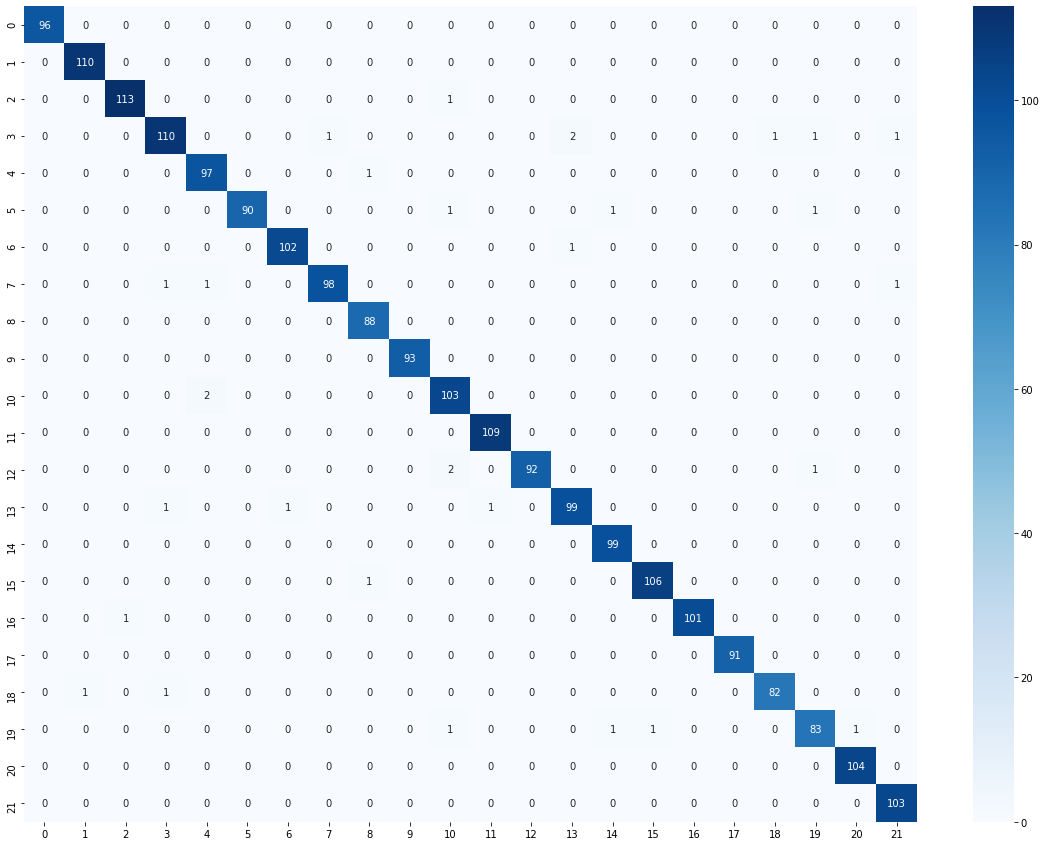

In [46]:
#Create confusion matrix for Custom CNN Model
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix,precision_score
cnf_metrics = confusion_matrix(prediction_list,list(test['language']))
cnf_metrics

#Creating a confusion matrix for the predicted output
import seaborn as sns
plt.figure(figsize=(20, 15))
axis = plt.subplot(111)
sns.heatmap(cnf_metrics, ax = axis, cmap = 'Blues', annot = True, square = False, fmt='')

#Calculating accuracy based in the confusion matrix for BERT Multi-Cased-Model 
#Accuracy is calculated by ratio of all true predictions and total number of images 
#Trace function is used to calculate sum of all diagonal value (True predictions)
bert_accuracy = cnf_metrics.trace()/cnf_metrics.sum()
print("Accuracy for BERT Multi-Cased-Model : ", bert_accuracy)

#Getting F1 micro score for BERT Multi-Cased-Model 
from sklearn.metrics import f1_score
bert_f1 = f1_score(prediction_list,list(test['language']), average = 'micro')
print("F1 score (micro) for BERT Multi-Cased-Model  : ", bert_f1)

#Getting F1 macro score for BERT Multi-Cased-Model 
from sklearn.metrics import f1_score
bert_f1_ma = f1_score(prediction_list,list(test['language']), average = 'macro')
print("F1 score (macro) for BERT Multi-Cased-Model  : ", bert_f1_ma)

bert_precision = precision_score(prediction_list,list(test['language']), average = 'macro')
print("Precision Score for BERT Multi-Cased-Model  : ", bert_precision)


In [48]:
results = pd.DataFrame({
    'Proposed Model': ['BERT Multi-Cased Model'],
    'Accuracy': [bert_accuracy],
    'F1-score(micro)': [bert_f1],
    'F1-score(macro)': [bert_f1_ma],
    'Precision-score': [bert_precision]})
results

,Proposed Model,Accuracy,F1-score(micro),F1-score(macro),Precision-score
0,BERT Multi-Cased Model,0.985909,0.985909,0.985904,0.986099


In [49]:
print("""BERT Multi-Cased Model for Language Identification Task""")
#Creating a Table to store the above output.

from tabulate import tabulate
print(tabulate(results,headers="keys",tablefmt="fancy_grid"))

BERT Multi-Cased Model for Language Identification Task
╒════╤════════════════════════╤════════════╤═══════════════════╤═══════════════════╤═══════════════════╕
│    │ Proposed Model         │   Accuracy │   F1-score(micro) │   F1-score(macro) │   Precision-score │
╞════╪════════════════════════╪════════════╪═══════════════════╪═══════════════════╪═══════════════════╡
│  0 │ BERT Multi-Cased Model │   0.985909 │          0.985909 │          0.985904 │          0.986099 │
╘════╧════════════════════════╧════════════╧═══════════════════╧═══════════════════╧═══════════════════╛
